# Generation of data
The data are in the form of 

$$x_i \sim \mathcal{N}(0, \Sigma), \quad i = 1, \dots, N, \quad x_i \in \mathrm{R}^d$$

with the singular value decomposition $\Sigma = U D U^T \in \mathrm{R}^{d \times d}$ where $U$ are real and orthonormal, i.e $UU^T = I$, and $D$ is a diagonal matrix.

To generate the data, specify the singular values, `singular_vals`, the dimensions $N$ and $d$, and the matricies $U, V$. The default value of the covariance matrix is $\Sigma = I_{d\times d}$. 

In [203]:
import sys
sys.path.insert(0, '../Src')

import numpy as np
import time
from scipy.stats import ortho_group
import DiffusionCopy as df
import plotting
import matplotlib.pyplot as plt
from utils import get_embedding_mse
np.random.seed(123)

In [12]:
# set parameters 
N = 1000
d = 10

In [14]:
def generate_gaussian_data(N, d, s=np.ones(d), U=np.identity(d), normalize=True):
    sigma = U @ np.diag(s) @ U.T
    X = np.random.multivariate_normal(np.zeros(len(s)), sigma, size=N)
    if normalize:
        return (X.T / np.linalg.norm(X, axis=1)).T
    return X 

In [15]:
# generate data
X_identity = generate_gaussian_data(N, d, normalize=True)

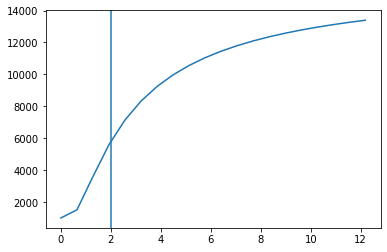

In [81]:
# find loglog scale parameter
sigmas =  np.linspace(np.exp(-5), np.exp(2.5), 20) 
# sigmas = np.exp(sigmas_log)
Ls = []
for sigma in sigmas:
    _, eig = df.diffusion_map(X_identity,sigma=sigma)
    affinity = eig["affinity"]
    Ls.append(affinity.sum())
    
plt.plot(sigmas, Ls)
plt.axvline(x=2.)
plt.show()

In [14]:
# plot eigenvalues 

def inspect_eigenvalues(X_train, title, ts=[1,2], mod=None, show=True, num_eig_plot=None):
    if len(ts) != 2:
        raise Exception(f"ts should be of length 2, but has {len(ts)} values. Can only compare two different values.")
    if mod is not None:
        X_train = modify_dataset(X_train, phi)
    if num_eig_plot is None:
        num_eig_plot = X_train.shape[0]
        
    dm_median_1, eig_median_1 = df.diffusion_map(X_train, sigma=0, t=ts[0])
    dm_adaptive_1, eig_adaptive_1 = df.diffusion_map(X_train, sigma="adaptive", t=ts[0])
    dm_median_2, eig_median_2 = df.diffusion_map(X_train, sigma=0, t=ts[1])
    dm_adaptive_2, eig_adaptive_2 = df.diffusion_map(X_train, sigma="adaptive", t=ts[1])

    fig , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharey=True)
    ax1.plot(eig_adaptive_1["vals"][:num_eig_plot]**ts[0], label="adaptive")
    ax1.plot(eig_median_1["vals"][:num_eig_plot]**ts[0], label="median")
    ax1.set_title(f"Eigenvalue decay, {title}, t={ts[0]}")
    ax1.set_ylabel("Value")
    ax1.set_xlabel("Position")
    ax1.legend()
    ax1.grid()

    ax2.plot(eig_adaptive_2["vals"][:num_eig_plot]**ts[1], label="adaptive")
    ax2.plot(eig_median_2["vals"][:num_eig_plot]**ts[1], label="median")
    ax2.set_title(f"Eigenvalue decay, {title}, t={ts[1]}")
    ax2.set_ylabel("Value")
    ax2.set_xlabel("Position")
    ax2.legend()
    ax2.grid()
    if show:
        plt.show()
    return (fig, (ax1, ax2))


def inspect_eigenvalues_for_sigmarange(X_train, sigmas, ts=[1, 2], title="", show=True, num_eig_plot=None):
    if len(ts) != 2:
        raise Exception(f"ts should be of length 2, but has {len(ts)} values. Can only compare two different values.")
    if num_eig_plot is None:
        num_eig_plot = X_train.shape[0]
        
    fig , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    for sigma in sigmas:
        df_1, eig_1 = df.diffusion_map(X_train, sigma=sigma, t=ts[0])
        ax1.plot(eig_1["vals"][:num_eig_plot], label=f"sigma={sigma}")
        ax1.set_title(f"Eigenvalue decay, {title}, t={ts[0]}")
        ax1.set_ylabel("Value")
        ax1.set_xlabel("Position")
        ax1.legend()
        ax1.grid()
        
        df_2, eig_2 = df.diffusion_map(X_train, sigma=sigma, t=ts[1])
        ax2.plot(eig_2["vals"][:num_eig_plot], label=f"sigma={sigma}")
        ax2.set_title(f"Eigenvalue decay, {title}, t={ts[1]}")
        ax2.set_ylabel("Value")
        ax2.set_xlabel("Position")
        ax2.legend()
        ax2.grid()
        
    if show:
        plt.show()
    
    return [ax1, ax2]


def inspect_eigenvalues_modified_data(X, title, mod=None):
    if mod is None:
        raise Exception("No modification.")

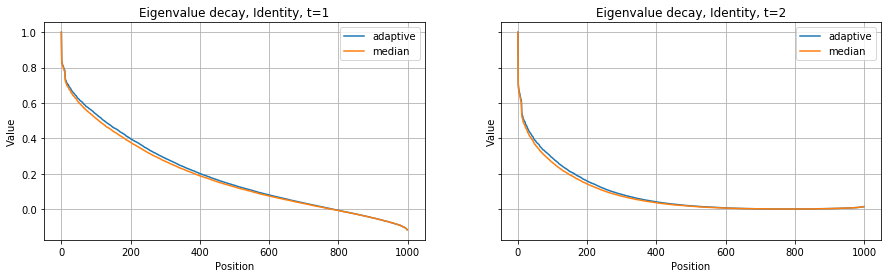

In [15]:
axes_identity = inspect_eigenvalues(X_identity, "Identity")

Now consider the case when the covariance matrix is diagonal with a gap between the values. 

In [5]:
singular_gap = np.concatenate((20*np.ones(int(d/2)), 0.*np.ones(int(d/2))))
X_gap = generate_gaussian_data(N, d, s=singular_gap, normalize=True)

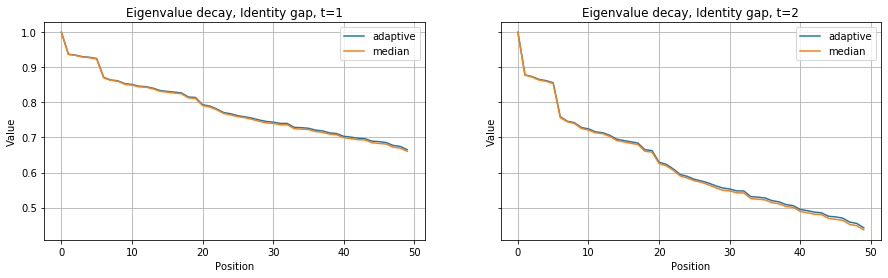

In [75]:
axes_gap = inspect_eigenvalues(X_gap, "Identity gap", num_eig_plot=50)

Consider the case when $\Sigma = U D U^T$, and $D$ is the same as in the previous case.

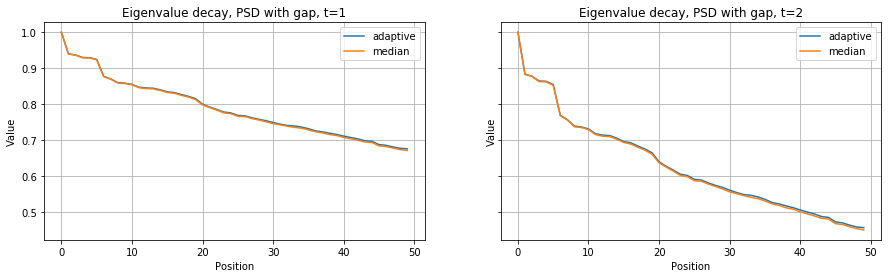

In [76]:
U = ortho_group.rvs(d)
X_decomp_gap = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=True)
axes_psd = inspect_eigenvalues(X_decomp_gap, "PSD with gap", num_eig_plot=50)

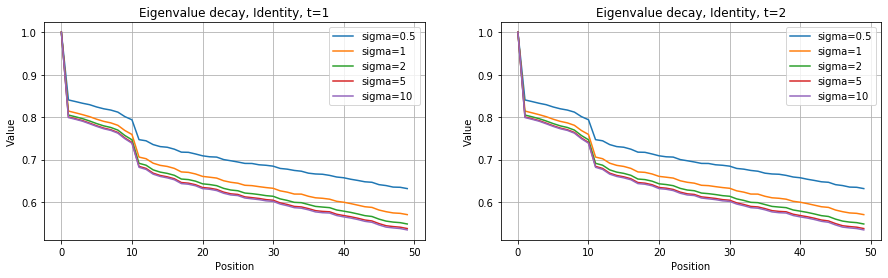

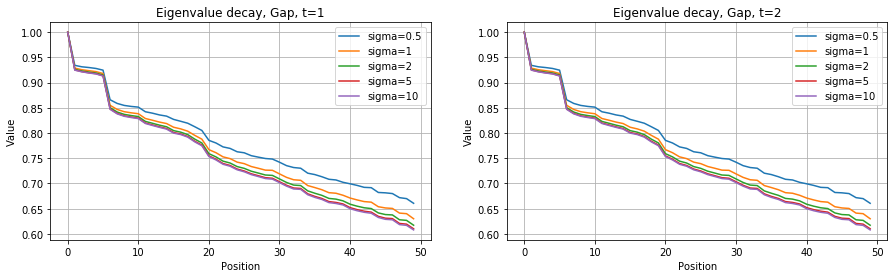

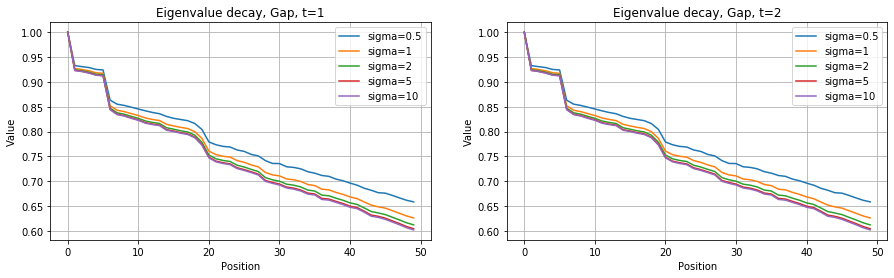

In [66]:
sigmas = [0.5, 1, 2, 5, 10]
axes_variable = inspect_eigenvalues_for_sigmarange(X_identity, sigmas, ts = [1, 2], title="Identity", num_eig_plot=50)
axes_variable = inspect_eigenvalues_for_sigmarange(X_gap, sigmas, ts = [1, 2], title="Gap", num_eig_plot=50)
axes_variable = inspect_eigenvalues_for_sigmarange(X_decomp_gap, sigmas, ts = [1, 2], title="Gap", num_eig_plot=50)

Pretty much the same eigenvalue decay for different t. 

Let's test the case when we have additional information, i.e. when the dataset is $X' = [X, \varphi(X)]$, where $\varphi(X): \mathbb{R}^d \rightarrow \mathbb{R}^k$ such that $x_i \rightarrow (x_i, \varphi (x_i)) \in  \mathbb{R}^{d+k}$

Consider first the case when $k=1$.
Let $\varphi(X) = x_1$, i.e the first column of $X$. 

Two embeddings calculated for the same $m$ datapoints are similar up to a rotation [[1]](https://arxiv.org/pdf/1209.0245.pdf). We can calculate the rotation between two embeddings $\Psi$ and $\tilde{\Psi}$ as 

$$
S[i, j] = \sum_{k=1}^m \tilde{\Psi_i}(k)^T \Psi_j(k).
$$

The SVD of $S$ is $U \Lambda V^T$, and the rotation matrix between $\Psi$ and $\tilde{\Psi}$ is given by $R=V U^T$. 

In [515]:
def modify_dataset(X, mod, alpha=1):
    return np.c_[X, alpha * mod(X)]

phi = lambda X: X[:,0]    

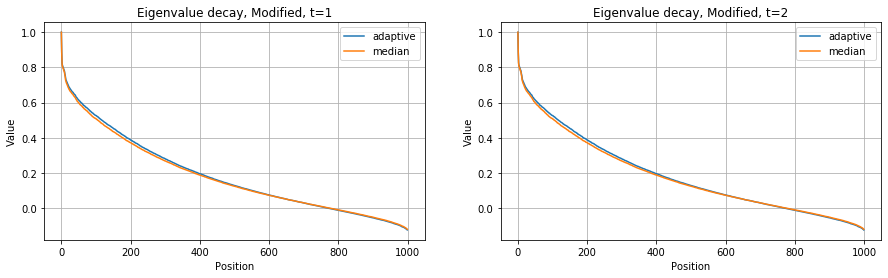

In [144]:
res = inspect_eigenvalues(X_identity, mod=phi, title="Modified")

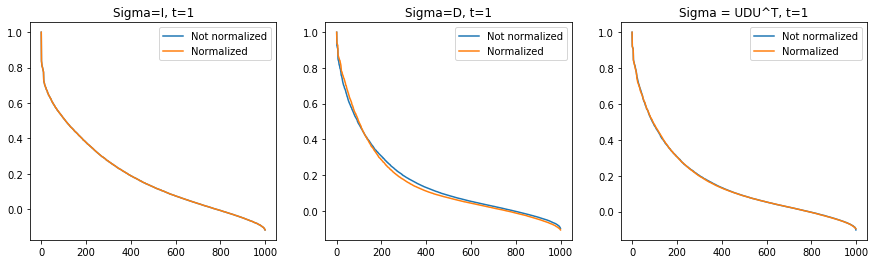

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

X_identity = generate_gaussian_data(N, d, normalize=False)
X_identity_norm = generate_gaussian_data(N, d, normalize=True)
_, eig = df.diffusion_map(X_identity)
_, eig_norm = df.diffusion_map(X_identity)
ax1.plot(eig["vals"], label="Not normalized")
ax1.plot(eig_norm["vals"], label="Normalized")
ax1.set_title("Sigma=I, t=1")
ax1.legend()

X_gap_norm = generate_gaussian_data(N, d, s=singular_gap, normalize=True)
X_gap = generate_gaussian_data(N, d, s=singular_gap, normalize=False)
_, eig = df.diffusion_map(X_gap)
_, eig_norm = df.diffusion_map(X_gap_norm)
ax2.plot(eig["vals"], label="Not normalized")
ax2.plot(eig_norm["vals"], label="Normalized")
ax2.set_title("Sigma=D, t=1")
ax2.legend()

U = ortho_group.rvs(d)
X_decomp_gap = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=False)
X_decomp_gap_norm = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=False)

_, eig = df.diffusion_map(X_decomp_gap)
_, eig_norm = df.diffusion_map(X_decomp_gap_norm)

ax3.plot(eig["vals"], label="Not normalized")
ax3.plot(eig_norm["vals"], label="Normalized")
ax3.set_title("Sigma = UDU^T, t=1")
ax3.legend()
plt.show()

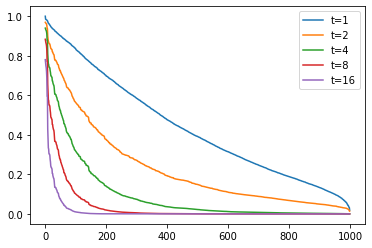

In [20]:
ts = [1, 2, 4, 8, 16]
for t in ts:
    _, eig = df.diffusion_map(X_decomp_gap_norm, sigma=2, t=t)
    P_t = eig["mat"]**t
    vals, vec = np.linalg.eig(P_t)
    plt.plot(np.sort(vals)[::-1], label=f"t={t}")
    plt.legend()
plt.show() 

In [66]:

def get_encoder_mse(embed_1, embed_2):
    matrix_shape = embed_1.shape[1]
    S = np.zeros((matrix_shape, matrix_shape))
    for i in range(matrix_shape):
        for j in range(matrix_shape):
            S[i, j] = np.dot(embed_1[:, i], embed_2[:, j])
    u, _, v = np.linalg.svd(S)
    R = v.T @ u.T
    return np.mean(np.linalg.norm(embed_1 - (R @ embed_2.T).T, ord=2, axis=1)**2)

In [85]:
U = ortho_group.rvs(d)
singular_gap = np.concatenate((20*np.ones(int(d/2)), 0.*np.ones(int(d/2))))
X = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=True)
X_mod = modify_dataset(X, phi)

embed, _ = df.diffusion_map(X)
embed_mod_1, _ = df.diffusion_map(X_mod)


In [86]:
get_embedding_mse(embed, embed_mod_1)

(3, 1000)


0.46906229144106565

In [94]:
phi = lambda X: np.mean(X, axis=1)
X_mod = modify_dataset(X, phi)
embed_mod_2, _ = df.diffusion_map(X_mod)
get_embedding_mse(embed, embed_mod_2)

(3, 1000)


0.14221449333642913

# Compare diffusion distance with the nearest neighbors

In [225]:
from scipy.spatial import distance_matrix

file_id = "random_gap"
d=10
N=1000
# U = ortho_group.rvs(d)
# diagonal = np.random.random(d)
U = np.identity(d)
diagonal = np.ones(int(d))
X = generate_gaussian_data(N, d, U=U, s=diagonal, normalize=True)

In [226]:
euclidean_dmat = distance_matrix(X, X, p=2) 
k_nearest = 1
euclidean_argmat = np.argsort(euclidean_dmat, axis=1)
nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]

experiment_id = str(int(time.time()))

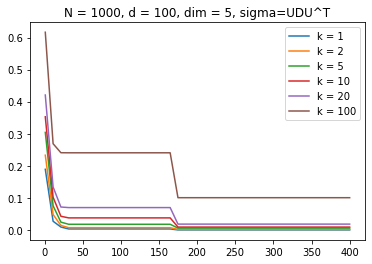

In [230]:
ts = np.linspace(1, 400, 40)
dim = 5
N=1000
ks = [1, 2, 5, 10, 20, 100]

fig1 = plt.figure()
for k_nearest in ks:
    nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]
    scores = []
    _, eig = embedding, eig = df.diffusion_map(X, k=X.shape[0], dim=dim, sigma=0, kernel="gaussian")
    for t in ts: 
        embed = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)])**t)
        dm_dmat = distance_matrix(embed, embed, p=2)
        dm_argmat = np.argsort(dm_dmat, axis=1)
        nn_nearest_dm = [argsorted[1:(k_nearest+1)] for argsorted in dm_argmat]
        score = np.sum([len(np.intersect1d(nn_nearest[i], nn_nearest_dm[i], assume_unique=True)) 
                        for i in range(len(nn_nearest))])
        scores.append(score)
    plt.plot(ts, np.array(scores)/(k_nearest*N), label = f"k = {k_nearest}")
    
plt.title(f"N = {N}, d = {d}, dim = {dim}, sigma=UDU^T")
plt.legend()
plt.show()
fig1.savefig(f"../Pics/{file_id}_k_{experiment_id}.png")

When considering different values of nearest neighbors on the rank statistic, the score decreases earlier for larger $k$, but it seems to break down at the same time. 

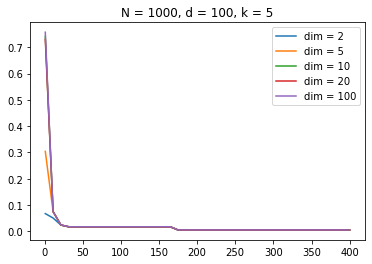

In [231]:
ts = np.linspace(1, 400, 40)
dims = [2, 5, 10, 20, 100]
k_nearest = 5

nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]

fig = plt.figure()
for dim in dims:
    scores = []
    _, eig = embedding, eig = df.diffusion_map(X, k=X.shape[0], dim=dim, sigma=0, kernel="gaussian")
    for t in ts: 
        embed = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)])**t)
        dm_dmat = distance_matrix(embed, embed, p=2)
        dm_argmat = np.argsort(dm_dmat, axis=1)
        nn_nearest_dm = [argsorted[1:(k_nearest+1)] for argsorted in dm_argmat]
        score = np.sum([len(np.intersect1d(nn_nearest[i], nn_nearest_dm[i], assume_unique=True)) 
                        for i in range(len(nn_nearest))])
        scores.append(score)
    plt.plot(ts, np.array(scores)/(k_nearest*N), label = f"dim = {dim}")
    
plt.title(f"N = {N}, d = {d}, k = {k_nearest}")
plt.legend()
plt.show()
fig.savefig(f"../Pics/{file_id}_dim_{experiment_id}.png")

There is no difference in the rank score, when considering different embedding sizes. This validates that most of the information is in the first few coordinates in the embedding space. 

Let's test for different $N$. 

Done with 100
Done with 500
Done with 1000
Done with 5000


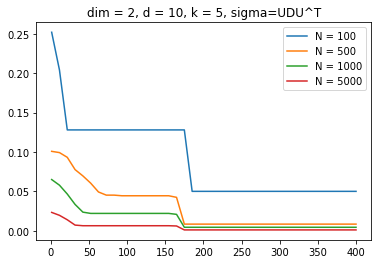

In [232]:
ts = np.linspace(1, 400, 40)
dim = 2
k_nearest = 5
Ns = [100, 500, 1000, 5000]
d = 10


fig = plt.figure()
for N in Ns:
    X = generate_gaussian_data(N, d, U=U, s=diagonal, normalize=True)
    euclidean_dmat = distance_matrix(X, X, p=2) 
    k_nearest = 5
    euclidean_argmat = np.argsort(euclidean_dmat, axis=1)
    nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]
    
    scores = []
    _, eig = embedding, eig = df.diffusion_map(X, k=X.shape[0], dim=dim, sigma=0, kernel="gaussian")
    for t in ts: 
        embed = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)])**t)
        dm_dmat = distance_matrix(embed, embed, p=2)
        dm_argmat = np.argsort(dm_dmat, axis=1)
        nn_nearest_dm = [argsorted[1:(k_nearest+1)] for argsorted in dm_argmat]
        score = np.sum([len(np.intersect1d(nn_nearest[i], nn_nearest_dm[i], assume_unique=True)) 
                        for i in range(len(nn_nearest))])
        scores.append(score)
    plt.plot(ts, np.array(scores)/(k_nearest*N), label = f"N = {N}")
    
    print(f"Done with {N}")
    
plt.title(f"dim = {dim}, d = {d}, k = {k_nearest}, sigma=UDU^T")
plt.legend()
plt.show()
fig.savefig(f"../Pics/{file_id}_N_{experiment_id}.png")

Done with 2
Done with 5
Done with 10
Done with 50
Done with 100


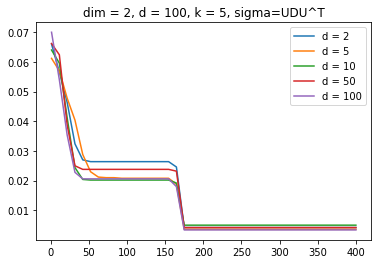

In [233]:
ts = np.linspace(1, 400, 40)
dim = 2
k_nearest = 5
ds = [2, 5, 10, 50, 100]
N = 1000


fig = plt.figure()
for d in ds:
    X = generate_gaussian_data(N, d, U=U, s=diagonal, normalize=True)
    euclidean_dmat = distance_matrix(X, X, p=2) 
    k_nearest = 5
    euclidean_argmat = np.argsort(euclidean_dmat, axis=1)
    nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]
    
    scores = []
    _, eig = embedding, eig = df.diffusion_map(X, k=X.shape[0], dim=dim, sigma=0, kernel="gaussian")
    for t in ts: 
        embed = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)])**t)
        dm_dmat = distance_matrix(embed, embed, p=2)
        dm_argmat = np.argsort(dm_dmat, axis=1)
        nn_nearest_dm = [argsorted[1:(k_nearest+1)] for argsorted in dm_argmat]
        score = np.sum([len(np.intersect1d(nn_nearest[i], nn_nearest_dm[i], assume_unique=True)) 
                        for i in range(len(nn_nearest))])
        scores.append(score)
    plt.plot(ts, np.array(scores)/((k_nearest*N)), label = f"d = {d}")
    
    print(f"Done with {d}")
    
plt.title(f"dim = {dim}, d = {d}, k = {k_nearest}, sigma=UDU^T")
plt.legend()
plt.show()
fig.savefig(f"../Pics/{file_id}_d_{experiment_id}.png")

# Adding extra information

Let's suppose the data are on the form $x_i \sim \mathcal{N}(0, I) \in \mathbb{R}^{d \times d}$, and for now set $d=2$. So the underlying manifold is a d-dimensional circle. We want to test that the diffusion map is capturing the underlying manifold when adding extra information to the features. The extra features could be a function of the existing features $\varphi(X) \in \mathrm{R}^k$, such that the data is transformed from $\mathrm{R}^d$ to $\mathrm{R}^{d+k}$. The hope is that the diffusion map is still able to capture the underlying manifold since essentially no new information is added.

We measure the performance by a rank metric defines as 

$$
R_k = \frac{1}{N k} \sum_{i=0}^N | \{x: x \in X \cap x \in K_{x_i}^{eu} \cap x \in K_{x_i}^{dm} \} |,
$$

where $K_{x_i}^{eu}$ is the set of $k$ nearest neighbours to $x_i$ measures in the euclidean distance, and $K_{x_i}^{dm}$ is the set of $k$ nearest neighbours to $x_i$ measures in the diffusion distance. The idea of the metric is that the diffusion distance shoud locally preserve the distances between data points, and the metric measures the average intersection size in the nearest neighbours sets. 



In [521]:
def get_euclidean_nn(X, k_nearest=1):
    euclidean_dmat = distance_matrix(X, X, p=2) 
    euclidean_argmat = np.argsort(euclidean_dmat, axis=1)
    nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]
    return nn_nearest


def get_rank_score(nn_euclidean, diffusion_embed, k_nearest=1):
    dm_dmat = distance_matrix(diffusion_embed, diffusion_embed, p=2)
    dm_argmat = np.argsort(dm_dmat, axis=1)
    nn_dm = [argsorted[1:(k_nearest+1)] for argsorted in dm_argmat]
    score = np.sum([len(np.intersect1d(nn_euclidean[i], nn_dm[i], assume_unique=True)) 
                    for i in range(len(nn_euclidean))])
    N = diffusion_embed.shape[0]
    return 1/(N*k_nearest) * score

In [563]:
d = 2 
N = 100
dim = 2 
U = np.identity(d)
diagonal = np.ones(int(d))
X = generate_gaussian_data(N, d, U=U, s=diagonal, normalize=True)
# different modifications
phi_1 = lambda X: X[:, 0]
X_mod_1 = modify_dataset(X, phi_1)

phi_2 = lambda X: 3 * X[:, 1]
X_mod_2 = modify_dataset(X, phi_2)

phi_3 = lambda X: X[:, 0] + X[:, 1]
X_mod_3 = modify_dataset(X, phi_3)

phi_4 = lambda X: X[:, 1]**2
X_mod_4 = modify_dataset(X, phi_4)

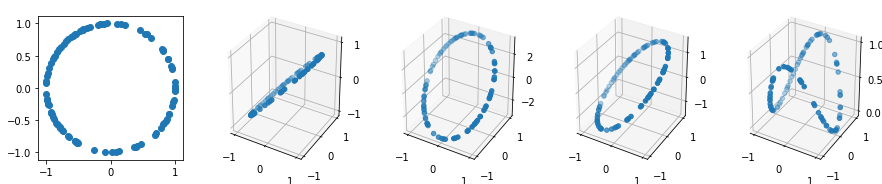

In [564]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,3))
ax1 = fig.add_subplot(1, 5, 1)
ax1.scatter(X[:, 0], X[:, 1])
ax1.axis('scaled')

ax2 = fig.add_subplot(1, 5, 2, projection="3d")
ax2.scatter(X_mod_1[:, 0], X_mod_1[:, 1], X_mod_1[:, 2])

ax2 = fig.add_subplot(1, 5, 3, projection="3d")
ax2.scatter(X_mod_2[:, 0], X_mod_2[:, 1], X_mod_2[:, 2])

ax3 = fig.add_subplot(1, 5, 4, projection="3d")
ax3.scatter(X_mod_3[:, 0], X_mod_3[:, 1], X_mod_3[:, 2])

ax4 = fig.add_subplot(1, 5, 5, projection="3d")
ax4.scatter(X_mod_4[:, 0], X_mod_4[:, 1], X_mod_4[:, 2])

plt.show()

data_modificatioins = [X_mod_1, X_mod_2, X_mod_3, X_mod_4]

One can see how the data are tilted and stretched into the higher dimensional space, but the underlying manifold is still the same. 

Now let's compute the rank statistic for each modification and compare with different values of $t$. 

In [507]:
k_nearest = 1
euclidean_dmat = distance_matrix(X, X, p=2) 
euclidean_argmat = np.argsort(euclidean_dmat, axis=1)
nn_nearest = [argsorted[1:(k_nearest+1)] for argsorted in euclidean_argmat]

embed, eig = df.diffusion_map(X, k=X.shape[0], dim=dim, sigma=0, kernel="gaussian")
ts = np.linspace(1, 400, 40)

all_eigs = [eig]
scores = []
for t in ts:
    embed_t = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)])**t)
    score = get_rank_score(nn_nearest, embed_t, k_nearest=k_nearest)
    scores.append(score)

scores_all_mods = []

for X_mod in data_modificatioins:
    scores_mod = []
    embed_mod, eig_mod = df.diffusion_map(X_mod, k=X_mod.shape[0], dim=dim, sigma=0, kernel="gaussian")
    all_eigs.append(eig_mod)
    for t in ts:

        embed_mod_t = np.matmul(eig_mod["vecs"][:, 1:(dim+1)], np.diag(eig_mod["vals"][1:(dim+1)])**t)
        scores_mod.append(get_rank_score(nn_nearest, embed_mod_t, k_nearest=k_nearest))
        
    scores_all_mods.append(scores_mod)


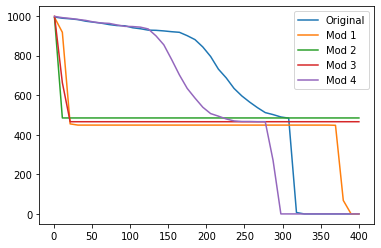

In [508]:
plt.plot(ts, scores, label="Original")
for i, scores_mod in enumerate(scores_all_mods):
    plt.plot(ts, scores_mod, label=f"Mod {i+1}")
plt.legend()
plt.show()

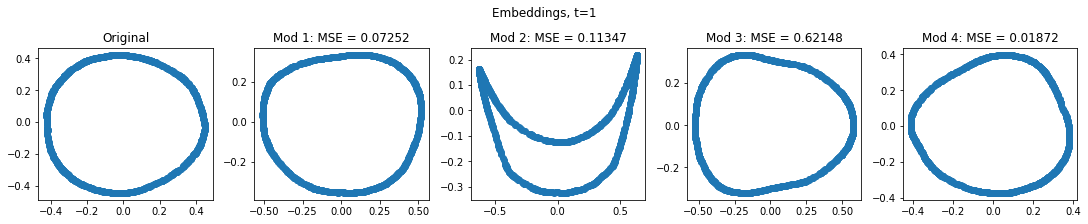

In [509]:
fig, axes = plt.subplots(nrows=1, ncols=len(data_modificatioins) + 1, figsize=(15, 3), constrained_layout=True)
fig.suptitle("Embeddings, t=1")
axes[0].plot(embed[:,0], embed[:,1], 'o', label=f"Original")
axes[0].set_title("Original")
for i, eig in enumerate(all_eigs[1:]):
    embed_mod = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)]))
    axes[i+1].plot(embed_mod[:,0], embed_mod[:,1], 'o', label=f"Mod {i+1}")
    axes[i+1].set_title(f"Mod {i+1}: MSE = {round(get_embedding_mse(embed, embed_mod), 5)}")
plt.show()
fig.savefig("../Pics/embeddings_w_modifications.png")

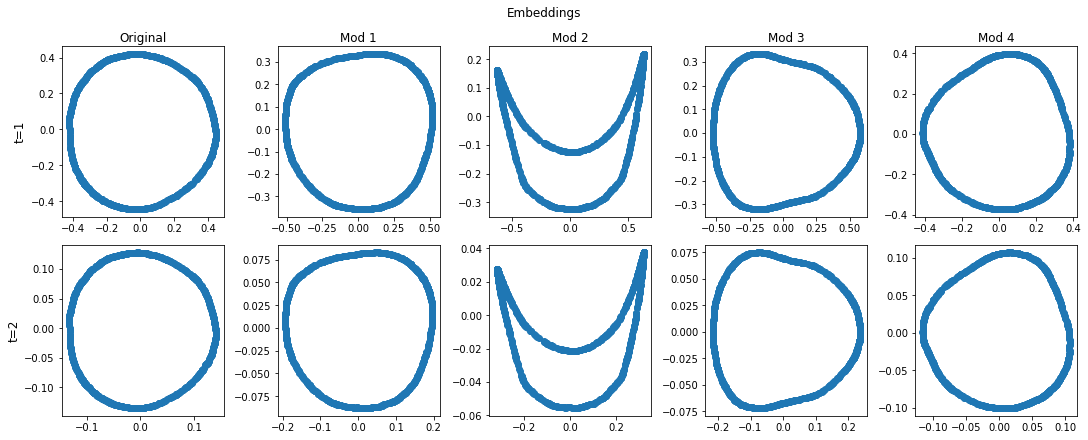

In [510]:
ts = [1, 2]
fig, axes = plt.subplots(nrows=len(ts), ncols=len(all_eigs), figsize=(15, 3*len(ts)), constrained_layout=True)
fig.suptitle("Embeddings")

for i, t in enumerate(ts):
    for j, eig in enumerate(all_eigs):
        embed = np.matmul(eig["vecs"][:, 1:(dim+1)], np.diag(eig["vals"][1:(dim+1)])**t)
        axes[i, j].plot(embed[:,0], embed[:,1], 'o')

for t, ax in zip(ts, axes[:,0]):
    ax.set_ylabel(f"t={t}", rotation=90, size='large')

for i, ax in enumerate(axes[0,:]):
    if i==0:
        ax.set_xlabel(f"Original", size='large')
        ax.xaxis.set_label_position('top') 
    else:
        ax.set_xlabel(f"Mod {i}", size='large')
        ax.xaxis.set_label_position('top') 

We observe that the embedding is not preserved when stretching one of the coordinates by a constant as a new feature. To investigate this further, consider the case when the transformed data are on the form $(x_1, x_2) \rightarrow (x_1, x_2, \alpha x_2 )$ for some $\alpha > 0$. We expect the embedding to be worse for larger $\alpha$, but still get better for larger $N$. 

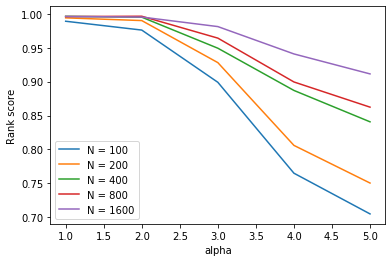

In [540]:
Ns = [100, 200, 400, 800, 1600]
k_nearest = 1
d = 2 
dim = 2 
U = np.identity(d)
diagonal = np.ones(int(d))

k_nearest = 1
alphas = np.linspace(1, 5, 5)
phi = lambda X: X[:, 1]
num_runs = 10

fig = plt.figure()
for N in Ns:
    scores_alpha = np.zeros((num_runs, len(X_modifications)))
    
    for i in range(num_runs):
        X = generate_gaussian_data(N, d, U=U, s=diagonal, normalize=True)
        euclidean_nn = get_euclidean_nn(X, k_nearest=k_nearest)
        X_modifications = [modify_dataset(X, phi, alpha) for alpha in alphas]
    
        for j, X_mod in enumerate(X_modifications):
            # use the default t=1 
            embed, _ = df.diffusion_map(X_mod, k=X_mod.shape[0], dim=dim, sigma=0, kernel="gaussian", t=1)
            scores_alpha[i, j] = get_rank_score(euclidean_nn, embed, k_nearest = k_nearest)
        
    plt.plot(alphas, np.mean(scores_alpha, axis=0), label=f"N = {N}")

plt.legend()
plt.xlabel("alpha")
plt.ylabel("Rank score", rotation=90)
plt.show()

Now let's consider the case when we add the square of one feature in the modified dataset. On the unit circle we observed that the embedding behaved nicely, but consider the case when we increase the radius of the data distribution. 

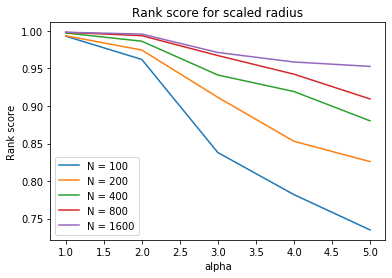

In [566]:
Ns = [100, 200, 400, 800, 1600]
k_nearest = 1
d = 2 
dim = 2 
U = np.identity(d)
diagonal = np.ones(int(d))

k_nearest = 1
alphas = np.linspace(1, 5, 5)
phi = lambda X: X[:, 1]**2
num_runs = 10

fig = plt.figure()
for N in Ns:
    scores_alpha = np.zeros((num_runs, len(alphas)))
    
    for i in range(num_runs):
        X = generate_gaussian_data(N, d, U=U, s=diagonal, normalize=True)
        
        for j, alpha in enumerate(alphas):
            X_scale = alpha * X
            euclidean_nn = get_euclidean_nn(X_scale, k_nearest=k_nearest)
            X_mod = modify_dataset(X_scale, phi)
    
            # use the default t=1 
            embed, _ = df.diffusion_map(X_mod, k=X_mod.shape[0], dim=dim, sigma=0, kernel="gaussian", t=1)
            scores_alpha[i, j] = get_rank_score(euclidean_nn, embed, k_nearest = k_nearest)
        
    plt.plot(alphas, np.mean(scores_alpha, axis=0), label=f"N = {N}")

plt.legend()
plt.xlabel("alpha")
plt.ylabel("Rank score", rotation=90)
plt.title("Rank score for scaled radius")
plt.show()